# Requirements and initialisation

In [2]:
import cosima_cookbook as cc

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft

import IPython.display

# Start Dask
from dask.distributed import Client
client = Client()

# Start COSIMA DB session
session = cc.database.create_session()

# Load data

In [3]:
# List all available experiments
# print(cc.querying.get_experiments(session)['experiment'].values)

# Experiments to fetch and their corresponding titles
expts = [
    {
        "name": "01deg_jra55v13_iaf",
        "title": "0.1° horizontal resolution",
    },
    {
        "name": "025deg_jra55v13_iaf_gmredi6",
        "title": "0.25° horizontal resolution",
    },
    # Error - variable "u" not found
    #{
    #    "name": "1deg_jra55v13_iaf_spinup1_B1_lastcycle",
    #    "title": "1° horizontal resolution",
    #}
]

for i, expt in enumerate(expts):
    u = cc.querying.getvar(
        expt=expt["name"],
        variable="u",
        session=session,
        ncfile="ocean.nc",
    )
    
    v = cc.querying.getvar(
        expt=expt["name"],
        variable="v",
        session=session,
        ncfile="ocean.nc",
    )
    
    speed = cc.querying.getvar(
        expt=expt["name"],
        variable="speed",
        session=session,
        ncfile="ocean.nc",
    )
    
    # Eddy kinetic energy
    eke = (u-u.mean(dim="time"))**2 + (v-v.mean(dim="time"))**2

    expts[i]["data"] = xr.merge([u, v, speed, eke.rename("eke")])

# Plots

## Define common variables

In [4]:
# Load land
land_50m = cft.NaturalEarthFeature(
    'physical',
    'land',
    '50m',
    edgecolor='black',
    facecolor='gray',
    linewidth=0.5,
)

## Zonal velocity - global

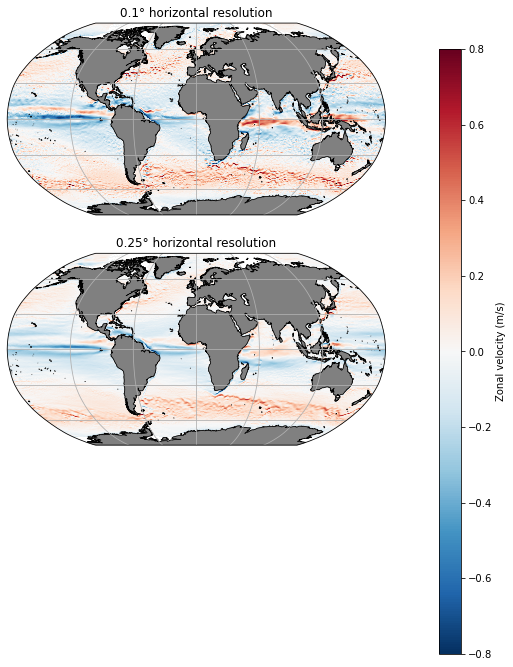

In [23]:
# Initialise figure
plt.figure(figsize=(10,12))

for i, expt in enumerate(expts):
    # Initialise plot
    ax = plt.subplot(
        3,
        1,
        i+1,
        projection=ccrs.Robinson(), # Projection to use for plotting
        label=str(i)
    )

    # Add features and gridlines
    ax.coastlines(resolution="50m")
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=False)
    
    # Plot zonal velocity
    p = ax.pcolormesh(
        expt["data"].u.xu_ocean, # X
        expt["data"].u.yu_ocean, # Y
        # Select model level closest to surface; final timestamp
        expt["data"].u.sel(st_ocean=0, method="nearest").sel(time=expt["data"].time[-1]), # C
        transform=ccrs.PlateCarree(), # Data coordinate system
        cmap='RdBu_r', # Colormap to use
        vmin=-0.8, # Data range for colormap (min)
        vmax=0.8, # Data range for colormap (max)
    )
    
    ax.set_title(expt["title"])

# Add colorbar legend
cb = plt.colorbar(
    mappable=p,
    cax=plt.axes([0.85, 0.15, 0.03, 0.7]), # Axes into which to draw colorbar
    orientation="vertical",
)

cb.ax.set_ylabel("Zonal velocity (m/s)");

## Zonal velocity - regional

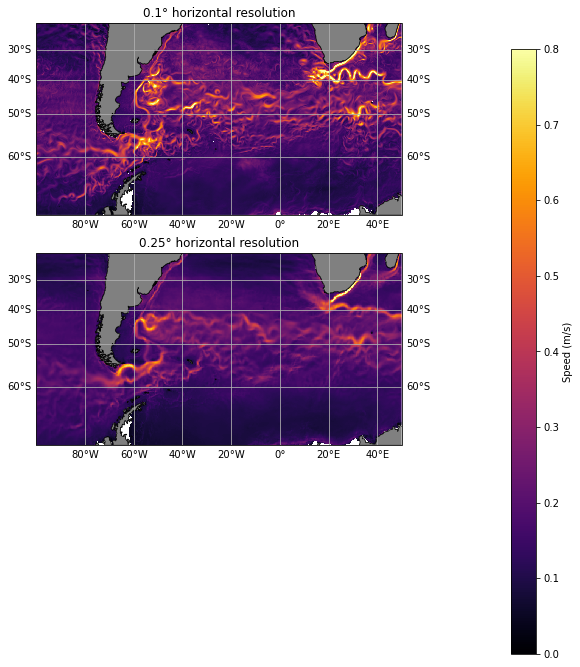

In [24]:
# Initialise figure
plt.figure(figsize=(12,12))

for i, expt in enumerate(expts):
    # Initialise plot
    ax = plt.subplot(
        3,
        1,
        i+1,
        # Projection to use for plotting, define projection extent
        projection=ccrs.Mercator(
            central_longitude=0.0,
            min_latitude=-70.0,
            max_latitude=-20.0,
        ),
        label=str(i),
    )

    # Set extent for region to be plotted
    ax.set_extent(
        [-100, 50, -70, -20],
        crs=ccrs.PlateCarree(), # Coordinate system of data to be plotted
    )
    
    # Add features and gridlines
    ax.coastlines(resolution="50m")
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    
    # Plot zonal velocity
    p = ax.pcolormesh(
        expt["data"].speed.xu_ocean, # X
        expt["data"].speed.yu_ocean, # Y
        # Select model level closest to surface; final timestamp
        expt["data"].speed.sel(st_ocean=0, method="nearest").sel(time=expt["data"].time[-1]), # C
        transform=ccrs.PlateCarree(), # Data coordinate system
        cmap="inferno", # Colormap
        vmin=0, # Data range for colormap (min)
        vmax=0.8, # Data range for colormap (max)
    )
    
    ax.set_title(expt["title"])

# Add colorbar legend
cb = plt.colorbar(
    mappable=p,
    cax=plt.axes([0.85, 0.15, 0.03, 0.7]), # Axes into which to draw colorbar
    orientation="vertical",
)

cb.ax.set_ylabel("Speed (m/s)");

## Eddy kinetic energy - regional
This plot will take some time to produce, since it requires averaging the entire time series of `u` and `v` for each simulation.

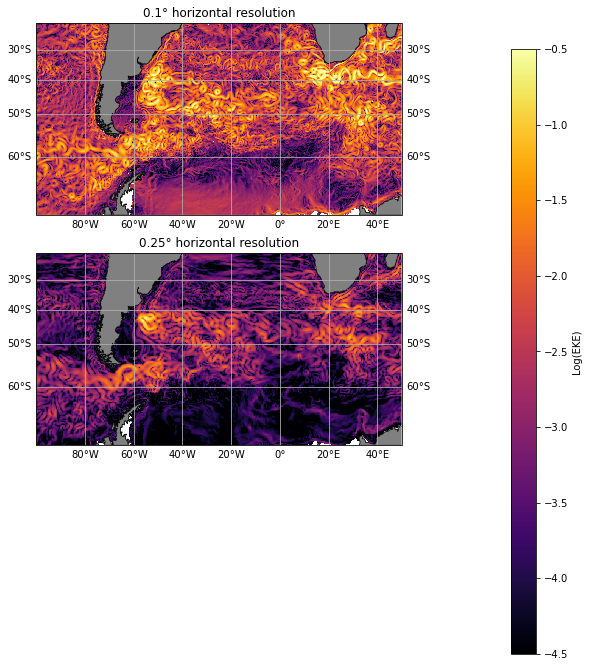

In [5]:
# Initialise figure
plt.figure(figsize=(12,12))

for i, expt in enumerate(expts):
    # Initialise plot
    ax = plt.subplot(
        3,
        1,
        i+1,
        # Projection to use for plotting, define projection extent
        projection=ccrs.Mercator(
            central_longitude=0.0,
            min_latitude=-70.0,
            max_latitude=-20.0
        ),
        label=str(i),
    )

    # Set extent for region to be plotted
    ax.set_extent(
        [-100, 50, -70, -20],
        crs=ccrs.PlateCarree(), # Coordinate system of data to be plotted
    )
    
    # Add features and gridlines
    ax.coastlines(resolution="50m")
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    
    p = ax.pcolormesh(
        expt["data"].eke.xu_ocean, # X
        expt["data"].eke.yu_ocean, # Y
        # Select model level closest to surface; final timestamp
        xr.ufuncs.log10(expt["data"].eke.sel(st_ocean=0, method="nearest").sel(time=expt["data"].time[-1])), # C
        transform=ccrs.PlateCarree(), # Data coordinate system
        cmap="inferno", # Colormap
        vmin=-4.5, # Data range for colormap (min)
        vmax=-0.5, # Data range for colormap (max)
    )
    
    ax.set_title(expt["title"])

# Add colorbar legend
cb = plt.colorbar(
    mappable=p,
    cax=plt.axes([0.85, 0.15, 0.03, 0.7]), # Axes into which to draw colorbar
    orientation="vertical",
)

cb.ax.set_ylabel("Log(EKE)");